# Projeto 1 - Ciência dos Dados
## Classificador de Notícias - Impacto da Tecnologia na Sociedade

Nome: Alex Souza Pacchioni

Nome: Rafael Dourado Bastos de Oliveira

___
Carregando as bibliotecas necessárias:

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import os

# Bibliotecas gráficas para facilitar a vizualização dos dados
import matplotlib.pyplot as plt
import seaborn as sn
from IPython.display import display

# Biblioteca para obtenção de stop words
import nltk
nltk.download('stopwords')

# Biblioteca que remove os warnings do Jupter Notbook para uma vizualização mais limpa do documento
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ivanp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
C:\Users\ivanp\OneDrive\Documentos\INSPER\2o. Semestre_2022\C.Dados\22-2a-cd-p1-grupo_rafaeldbo\notebooks


Carregando a base de dados com as notícias classificadas manualmente:

In [5]:
path = '../data/'
filename = 'dados.xlsx'

In [6]:
train = pd.read_excel(path+filename, sheet_name = 'Treinamento')
test = pd.read_excel(path+filename, sheet_name = 'Teste')

___
## Classificador automático


A tecnologia é um tema extremamente presente no cotidano mundial atualmente e, por isso, dezenas notícias sobre o assunto são postadas por mês. Tendo em vista essa importância, esse projeto tem o intuito de enteder melhor o impacto direto dessas noticias na sociedade por meio da categorização de notícias. Para isso, as notícias coletadas da plataforma *Isto é Dinheiro* na aba de *Tecnologia* foram separadas em **positivas** e **negativas** para que, por meio do **Classificador Naive-Bayes**, fosse possível descobrir a relação entre as palavras classíficadas. 

Para esse projeto foi o escolhido o **Classificador Naive-Bayes**  por ele ser especialmente conhecido por ter um bom desempenho em problemas de classificação de texto. Isso se deve pela sua capacidade de utilizar as probabilidades independentes da ocorrência de palavras em um texto para estimar a chance desse texto pertencer a certo grupo/conjunto.

**Tagets**
- 0: Negativas

Notícias classificadas como negativas são aquelas que não possuem relevancia para a sociedade em geral, como a venda do twitter, ou trazem informações ruins, como aumento de casos do Covid.
- 1: Positivas

Já para ser considerada positiva, a notícia ser relevante para a sociedade ou trazer informações que a beneficiam, como o avanço da vacinação e entrada de novas tecnologias no mercado.

___
### Montando um Classificador Naive-Bayes

Inicialmente, foi necessário realizar limpezas nos textos das notícias para remover conteúdos que pudessem atrapalhar a classificação das noticícias, como **Caracteres Especiais**, **Números** (pois fora de contexto eles perdem o sentido) e **Stop Words** (palavras muito comuns na construção de uma frases, mas, muitas vezes, são insignificantes para o sentido da frase). Para isso montou-se a função de limpeza abaixo:

In [7]:
stop_words = nltk.corpus.stopwords.words('portuguese')
special_characters= ',.@!#$%¨&*()–_-“”:;+‘’={}[]]?/\|…""><'+"''"

# Função de limpeza 
def cleanup (text):
    # removendo espaços e quebra de linhas desnecessários
    # colocando toda a notícia em minúsculo para que não haja essa diferenciação em palavras iguais
    text = text.strip().lower() 
    for word in special_characters: # rmovendo caracteres especiais
        text = text.replace(word, " ")

    text = text.strip().split() # transformando a noticia em uma lista
    clean_text = []
    for word in text:
        # removendo stop words e números
        if (word not in stop_words) and (not word.isnumeric()) and (len(word) > 1):
            clean_text.append(word) 

    return clean_text

# Limpando as notícias e as transformando em listas de palavras
train["Texto"] = train["Descrição"].apply(cleanup)

Após realizar a limpeza das notícias da base de treino, foi realizada a coleta de todas as palavras presentes nas noticias de treino para sabermos qual é o espaço amostral com o qual vamos trabalhar

In [8]:
# Coletando todas as palavras de todas as notícias
all_words = []
for words_list in train['Texto']:
    all_words += words_list
all_words = pd.Series(all_words) # Todas as palavras (com repetições)
portuguese = list(set(all_words)) # Todas as palavras (sem repetições)

Para aplicação do Classificador Naive-bayes se faz necessário conhecer a frequência relativa das palavras em determinado target - que é equivalente a probabilidade de que, caso essa palavra seja encontrada, ela pertença a um respectivo target.

Para encontrar essas frequências, a partir do espaço amostral anteriormente definido, separou-se as noticias de acordo com seus targets classificados manualmente e descobriu-se a **frequência absoluta** de cada palavra em seu respectivo target e a **probabilidade geral** de cada target:

In [9]:
# Filtrando a base de treino para cada target
train_bad = train.loc[train["Target"] == 0, :]
train_good = train.loc[train["Target"] == 1, :]

# Criando um Series com todas as palavras de cada target
series_bad = pd.Series(train_bad["Texto"].sum(axis= 0))
series_good = pd.Series(train_good["Texto"].sum(axis= 0))

# Obtendo a frequencia absoluta de cada palavra em cada target
table_bad = series_bad.value_counts()
table_good = series_good.value_counts()

# Calculando a probabilidade de cada target
prob_bad = (len(series_bad)/len(all_words))
prob_good = (len(series_good)/len(all_words))

display(table_bad.head(10).to_frame())
display(table_good.head(10).to_frame())

,0
feira,257
nesta,223
covid,126
saúde,111
casos,93
segundo,74
anos,72
contra,70
sobre,68
mundo,67


,0
feira,254
nesta,218
contra,111
covid,110
estados,82
unidos,76
anunciou,73
espacial,72
quinta,71
anos,71


Porém utilizar simplesmente a frêquencia relativa obtida pela divisão frequência absoluta da palavra pela quantidade de palavras pertencentes ao Target não será viável, pois podem haver palavras que não possue frequências definidas durante o treinamento, possuindo a frequência relativa 0.

Para resolver esse problema usaremos a **Suavização de Laplace** 

Para aplicá-la devemos adicionar 1 a frequência absoluta (no repectivo target) de cada palavra encontrada para que ela nunca seja 0. Porém, para equilibrar isso, adicionamos o número de palavras possíveis (total de palavras do target) ao divisor, para que o resultado dessa divisão nunca seja maior do que 1. Assim, obtemos a frequência relativa de cada palavra sem termos problema de possuir uma frequência 0.

$$P(palavra|target) = \frac{F_{target}+1}{P_{target}+P_{todas}}$$

Onde: 

$ F_{target}$: Frequência absoluta da palavra no target
    
$P_{target}$: Número de palavras pertencentes ao target

$P_{todas}$: Número de palavras na base de dados de treinamento (sem repetições)


In [10]:
# Suavizador de Laplace
def laplace_smoothing(words_list, amount):
    laplace_amount = amount + 1
    density = len(words_list) + len(portuguese)
    laplace = laplace_amount/density
    return laplace

Em posse de uma forma de calcular a frequência relativa individual de cada palavra em seu target evitando o problema da frequência 0, o próximo passo é calcular a propabilidade de uma notícia pertencer a cada target.

$$P(target|notícia)=\frac{P(palavra_1|target)P(palavra_2|target)...P(palavra_n|target) P(target)}{P(notícia)}$$

Por fim, define-se que a notícia pertence ao target que possui a mais probalidade resultante.

In [11]:
# Função que calcula a probabilidade de uma notícia ser de um determinado target 
def probability_target(table_target, series_target, news):
    
    list_target= []
    for word in news:
        amount = table_target[word] if word in table_target.keys() else 0
        list_target.append(laplace_smoothing(series_target, amount))
        
    probability_target = np.prod(list_target)
    return probability_target

# Função do Naive Bayes
def naive_bayes(news):
    prob_0 = probability_target(table_bad, series_bad, news) * prob_bad
    prob_1 = probability_target(table_good, series_good, news) * prob_good

    list_probs = [prob_0, prob_1]
    target = list_probs.index(max(list_probs))

    return target

#### Verificando a eficácia do Modelo no conjunto de treinamento

Para verificarmos se o classficador está funcionando como deveria, vamos testa-lo em sua própria base de treino e ver sua eficácia.

In [12]:
train["Classificacao"] = train["Texto"].apply(naive_bayes) # Aplicando o classificador

# Gerando uma tabela comparativa entre a classificação automática do Classificador e a manual feita por nós
performance_table = pd.crosstab(train["Classificacao"], train["Target"], normalize=True)

Para uma melhor vizualização desse resultado, usaremos o mapa de calor da biblioteca Seaborn [Fonte: https://seaborn.pydata.org]

Text(60.0, 0.5, 'Classificação Manual')

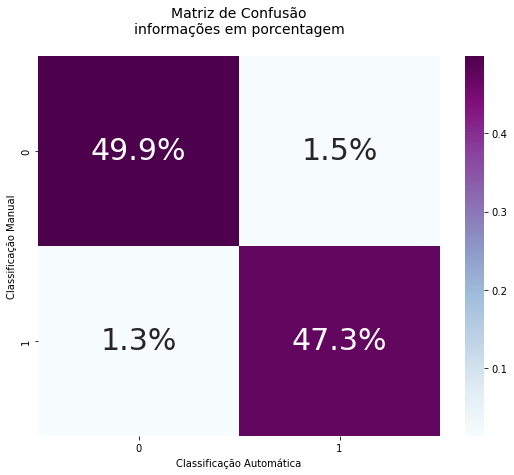

In [13]:
plt.figure(figsize = (9,7))
plt.title('Matriz de Confusão\ninformações em porcentagem\n',fontdict={'fontsize': 14})
sn.heatmap(performance_table, annot=True, annot_kws={"size":30},fmt='.1%',cmap="BuPu")
plt.xlabel('Classificação Automática')
plt.ylabel('Classificação Manual')

Por fim, vamos ver a acurácia do modelo:

In [14]:
accuracy = performance_table[0][0] + performance_table[1][1]
print(f'A acurácia do modelo foi de {accuracy*100:.2f}% quando aplicado na base de treinamento!')

A acurácia do modelo foi de 97.20% quando aplicado na base de treinamento!


___
### Verificando a performance do Classificador

Agora que sabemos que nosso modelo está funcionando de maneira aceitável vamos aplica-lo em uma nova base de dados: a base de teste. Para conhecermos a eficácia do nosso modelo diante a novas notícias, essa base de dados também foi classificada manualmente.

In [15]:
test["Texto"] = test["Descrição"].apply(cleanup) # Fazendo a limpeza das notícias
test["Classificacao"] = test["Texto"].apply(naive_bayes) # Aplicando o Classificador

performance_table = pd.crosstab(test["Classificacao"], test["Target"], normalize=True)

Text(60.0, 0.5, 'Classificação Manual')

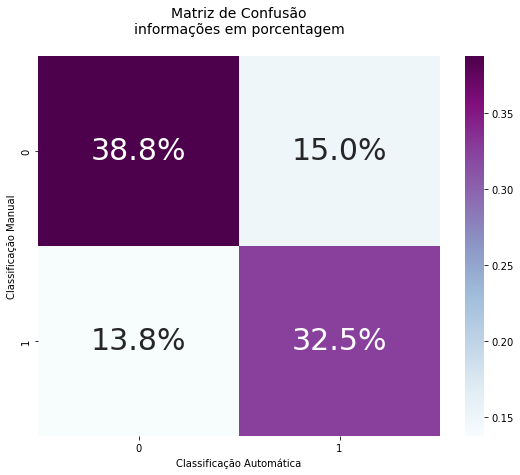

In [16]:
plt.figure(figsize = (9,7))
plt.title('Matriz de Confusão\ninformações em porcentagem\n',fontdict={'fontsize': 14})
sn.heatmap(performance_table, annot=True, annot_kws={"size":30},fmt='.1%',cmap="BuPu")
plt.xlabel('Classificação Automática')
plt.ylabel('Classificação Manual')

Por meio do mapa de calor é possível ver que a porcentagem de acerto do nosso classificador foi bastante significativa, mas para que fique mais clara a distribuição desse resultado vamos separa-los em *verdadeiros positivos*, *verdadeiros negativo*, *falsos positivos*, *falsos negativos* e ver a acurácia total do modelo.

Sendo:
- Verdadeiros positivos: notícias classificadas como **positivas corretamente**
- Verdadeiros negativos: notícias classificadas como **negativas corretamente**
- Falsos positivos: notícias classificadas como **positivas erroneamente**
- Falsos negativos: notícias classificadas como **negativas erroneamente**

In [17]:
true_positives = performance_table[0][0]
true_negatives = performance_table[1][1]
false_positives = performance_table[1][0]
false_negatives = performance_table[0][1]

In [18]:
accuracy = true_positives + true_negatives
print(f'A acurácia do modelo foi de {accuracy*100:.2f}% quando aplicado na base de testes!\n')

print(f'Porcentagem de Verdadeiros Positivos: {true_positives*100:.2f}%')
print(f'Porcentagem de Verdadeiros Negativos: {true_negatives*100:.2f}%')
print(f'Porcentagem de Falsos Positivos: {false_positives*100:.2f}%')
print(f'Porcentagem de Falsos Negativos: {false_negatives*100:.2f}%')

A acurácia do modelo foi de 71.25% quando aplicado na base de testes!

Porcentagem de Verdadeiros Positivos: 38.75%
Porcentagem de Verdadeiros Negativos: 32.50%
Porcentagem de Falsos Positivos: 15.00%
Porcentagem de Falsos Negativos: 13.75%


___
### Concluindo

Como visto nos resultados a cima, o classificador possui alta eficácia, *classificando corretamente cerca de 70% das notícias* da base de teste. É possivel notar que essa eficácia é bem menor do que a obtidida pela classificação automática da base de teste. Isso se da devido a ingenuidade do classificador que desconsidera relação de dependência entre as palavras. Por isso, muitos casos como: **ambiguidade**, **duplas negações**, **sarcasmos** ou **ironias**, podem ser classificados erroneamente, visto que ele analisará matematicamente a probabilidade idenpendente das palavras de constituição da notícia e não seu sentido na construção da informação.

Outro fator que colabora para essa redução no índice de acerto é o tamanho da base de dados, uma vez que para fins de um classificador efetivo ela teria de ser maior, principalmente para uma maior variedade de palavras tal qual melhor assimilação de padrões que possam aumentar a probabilidade de determinadas palavras e termos, aumentando consideravelmente a capacidade de generalização do modelo para com novas notícias.

Para aumentar a base de dados de treinamento parece tentador utilizar o próprio classificador para gerar novos dados de treino. Porém, isso não funcionaria como o esperado, isso ocorre principalmente por que o classificador não é perfeito - possui cerca de 30% de chance de errar uma clasificação. Assim, o erro gerado por ele será propagado em suas futuras classificações, diminuindo cada vez mais sua eficácia.

Vale-se destacar que como esse classificador tem modelagem quase que estritamente matemática, sem muitas considerações semânticas e humanas, sua perfomance foi considerável dentro do possível, e com isso, agregando fatores e melhorias abaixo, sua perfomance tende a melhorar conseguindo cumprir com extrema eficácia sua proposição esperada.

#### Melhorias para Implementações Futuras

- **Aplicação função logarítmica:**

 A aplicação do logaritmo se vê necessária unicamente nos valores de probabilidade de a notícia ser de cada um dos targets, tendo em mente que os valores se encontram em uma escala muito pequena. Tal método evita com que se gere uma defasagem na classificação da função do Naive Bayes, a qual poderia ter a classificação na comparação de probabilidades prejudicada pelos arredondamentos indesejados do Python.  

- **Lematização:** 

Como outros recursos de preparo/limpeza da base de dados, a lematização é uma estratégia de evitar a propagação de palavras de mesmo significado, englobando-as em uma que as abranja da forma mais básica removendo seus sufixos. Um exemplo disso seria a presença de palavras como *“infectados”* e *“infectando”*, as quais seriam reduzidas a *“infecção”*. Existem outros recursos que desenvolvem a mesma funcionalidade como o stemming, entretanto a lematização é a que apresenta resultados mais coerente, não deixando tantas palavras “fragmentadas” pela remoção dos sufixos. 

- **Ampliação a base de dados:** 

Por fim, outra importante melhoria seria a ampliação da base de treinamento através da classificação manual de mais notícias, pois, como já dito anteriormente, isso além de aumentar a variedade de palavras conhecidadas, permitiria que o classificador reconhecesse melhor os padrões encontrados em cada target, permitindo uma melhor generalização do modelo.

#### Outros usos para o Classificador Naive-Bayes

Por ser um classificador ótimo para aplicações rápidas, mas de baixa complexidade, o classificador Naive-bayes pode ser usado em **sistemas de recomendações de conteúdo**, analizando as padrões de preferência para a realização de uma propaganda. Outro uso pode ser na área médica, corrlacionando sintomas com possíveis doenças para auxiliar em **diagnósticos**.

#### Plano de Expansão

Com o aumento da escala do nosso projeto será possível identificar o progresso tecnológico de um país através das notícias circulando dentro dele. Permitindo, assim, que entidades competentes atuem em áreas de impacto positivo e mitiguem os dados das áreas prejudiciais a sociedade. Porém, para que o projeto alcance tais proporções será necessário um contínuo aprimoramento, a começar pela melhora da acurácia do classificador, para que suas análises sejam cada vez mais pertinentes e confiáveis.

___
### Qualidade do Classificador a partir de novas separações das notícias entre Treinamento e Teste

Por fim, para confirmar a eficácia do nosso modelo, vamos realizar uma série de embaralhamentos e separações entre as bases de treino e teste afim de verificar se acurácia do nosso é realmente a encontrada (cerca de 70%) ou se foi apenas um caso improvável.


In [19]:
new_test_amount = 500
all_news = pd.concat([train, test])
all_news['Classificacao'] = np.NaN

In [ ]:
list_accuracy = []
for i in range(new_test_amount):
    # Criando novas separeações aleatórias de treinamento e teste
    random_all_news = all_news.sample(frac=1).reset_index(drop=True)
    new_train = random_all_news.iloc[0:len(train), :]
    new_test = random_all_news.iloc[len(train):len(random_all_news), :]

    new_train["Texto"] = new_train["Descrição"].apply(cleanup)

    # Coletando todas as palavras
    all_words = []
    for words_list in new_train['Texto']:
        all_words += words_list
    all_words = pd.Series(all_words)
    portuguese = list(set(all_words))

    # Filtrando a base de treino para cada target
    train_bad = new_train.loc[new_train["Target"] == 0, :]
    train_good = new_train.loc[new_train["Target"] == 1, :]

    # Criando um Series com todas as palavras de cada target
    series_bad = pd.Series(train_bad["Texto"].sum(axis= 0))
    series_good = pd.Series(train_good["Texto"].sum(axis= 0))

    # Obtendo a frequencia absoluta de cada palavra em cada target
    table_bad = series_bad.value_counts()
    table_good = series_good.value_counts()

    # Calculando a probabilidade de cada target
    prob_bad = (len(series_bad)/len(all_words))
    prob_good = (len(series_good)/len(all_words))

    new_test["Texto"] = new_test["Descrição"].apply(cleanup)
    new_test["Classificacao"] = new_test["Texto"].apply(naive_bayes)

    performance_table = pd.crosstab(new_test["Classificacao"], new_test["Target"], normalize=True)

    # agora vamos calular acurácia do classificador
    accuracy = performance_table[0][0] + performance_table[1][1]
    list_accuracy.append(accuracy*100)

Após realizar uma quantidade considerável de testes com a base de dados aleatórizadas, vamos gerar um histograma para analizar distribuição das acurácias da aplicação do modelo.

In [ ]:
faixa=np.arange(min(list_accuracy) - 1, max(list_accuracy) + 1, 0.5)
plt.figure(figsize=(12, 5))
plt.hist(list_accuracy, bins=faixa, edgecolor='black', density=False)
plt.title('Frequência da acuracia do modelo')
plt.ylabel('Frequência')
plt.xlabel('Porcentagem de acerto (%)')
plt.xlim(min(list_accuracy) - 0.5, max(list_accuracy) + 1)
plt.show()

Como podemos ver no gráfico acima, a acurácia mais provável do nosso modelo com a base de dados atual é entre 70% e 72% o que, para um modelo com as limitações já apresentadas anteiormente, é extremamente razoavel.

___
## Aperfeiçoamento:

Trabalhos que conseguirem pelo menos conceito B vão evoluir em conceito dependendo da quantidade de itens avançados:

* IMPLEMENTOU outras limpezas e transformações que não afetem a qualidade da informação contida nas notícias. Ex: stemming, lemmatization, stopwords
* CONSIDEROU mais de duas caterogias na variável Target e INCREMENTOU a quantidade de notícias, mantendo pelo menos 250 notícias por caterogia (OBRIGATÓRIO PARA TRIOS, sem contar como item avançado)
* Para Target com duas categorias: CRIOU pelo menos quatro categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante
* EXPLICOU porquê não pode usar o próprio classificador para gerar mais amostras de treinamento
* PROPÔS diferentes cenários para Naïve Bayes fora do contexto do projeto (pelo menos dois cenários, exceto aqueles já apresentados em sala pelos professores: por exemplo, filtro de spam)
* SUGERIU e EXPLICOU melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)
* FEZ o item Qualidade do Classificador a partir de novas separações das Notícias entre Treinamento e Teste descrito no enunciado do projeto (OBRIGATÓRIO para conceitos A ou A+)

___
## Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Funcionamento**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Funcionamento**

[How to Improve Naive Bayes Classification Performance?](https://www.baeldung.com/cs/naive-bayes-classification-performance#introduction) **Melhorias**

[Stemming vs Lemmatization](https://www.baeldung.com/cs/stemming-vs-lemmatization) **Melhorias**

[All about Naive Bayes](https://towardsdatascience.com/all-about-naive-bayes-8e13cef044cf) **Outros usos**

[Naive Bayes: Como Funciona esse Algoritimo de Classificação](https://blog.somostera.com/data-science/naive-bayes#:~:text=Há%20usos%20de%20Naive%20Bayes,como%20filtragem%20colaborativa%20e%20outros) **Outros usos**



